In [ ]:
# colab 사용 시! Local PC로 실습하는 경우 실행 x / 단, 작업경로를 2025_LGE_DNN으로 맞춰주기

!git clone https://github.com/Im-JihyunKim/2025_LGE_DNN.git
%cd /content/2025_LGE_DNN

In [ ]:
from IPython.display import Image

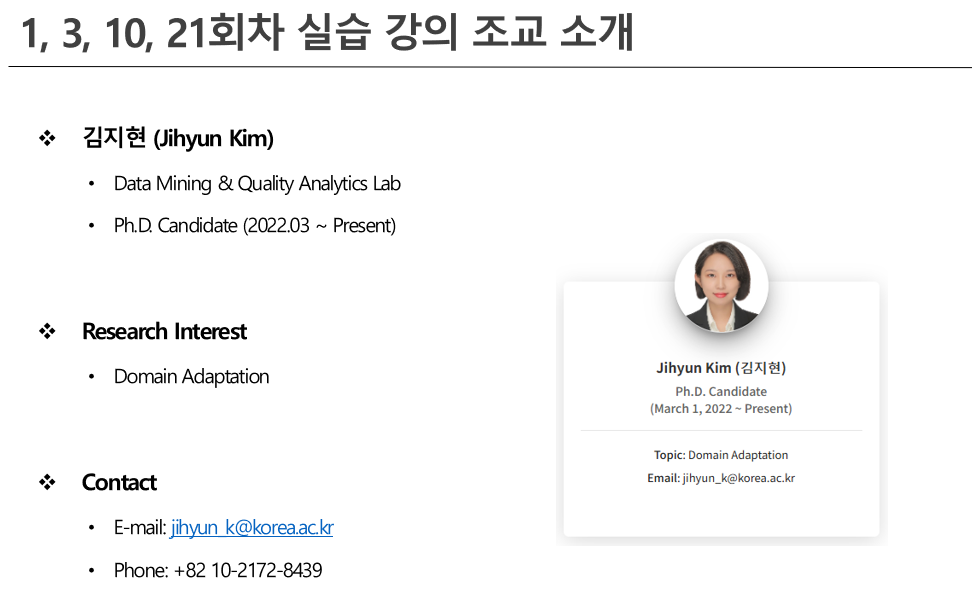

In [ ]:
Image('images/img0.png')

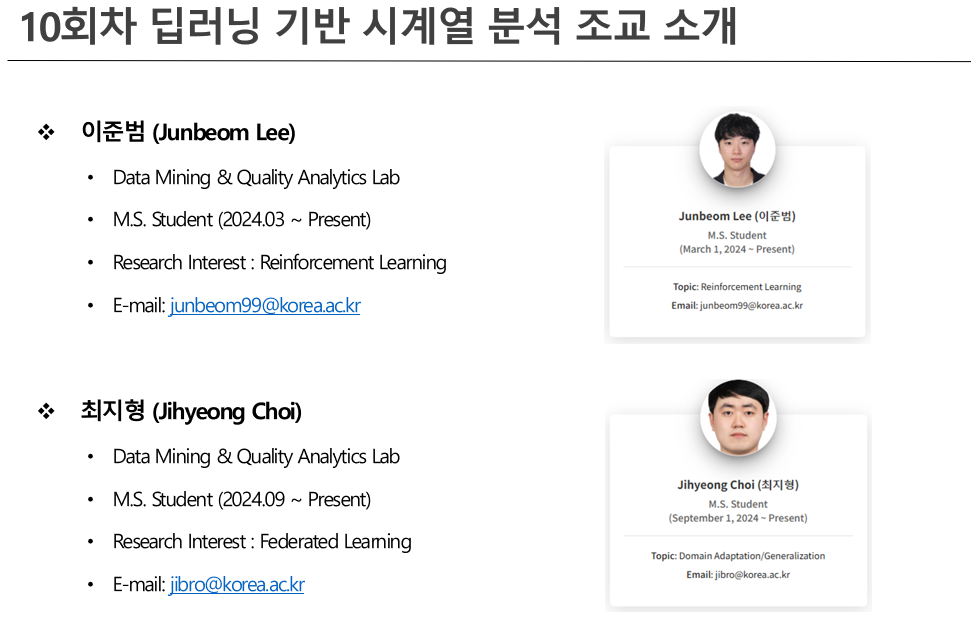

In [ ]:
Image('images/img00.PNG')

## 1. PyTorch Custom Dataset
- 데이터를 전처리하고 불러오는 과정을 정의
- Python 언어의 Class를 통해 구현됨 (데이터 로딩, 전처리, 후처리 등을 위한 코드를 모듈화하는 데 유용하기 때문)

In [ ]:
import torch
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

from torch.utils.data import Dataset

### (참고) Python Class

In [ ]:
class Calculator:
  def __init__(self):   # 객체 생성 시 호출될 때 자동으로 실행되는 초기화 함수 (클래스 초기 상태를 설정하는 데 사용)
    self.result = 0     # Calculator() 객체가 생성될 때 result라는 속성을 0으로 초기화
                        # self.는 현재 객체의 상태를 참조하는 데 사용하며, 따라서 클래스 내의 다른 메소드에서는 self.result를 통해 값의 접근 및 수정 가능

  # 메서드. 클래스 내에서 정의된 함수
  def add(self, num):   # 객체를 생성한 후 사용할 수 있는 함수, 인자 self는 메서드 add를 호출하는 객체가 전달됨
    self.result += num  # 현재 Calculator라는 객체의 result 속성 값에다 인자로 받은 'num' 값을 더해 결과를 다시 result로 할당
    return self.result  # 메소드를 호출한 곳에서 최신의 결과 값을 받을 수 있음

  def sub(self, num):   # 한 class 내에 여러가지 메서드를 구현할 수 있음
    self.result -= num  # 현재 Calculator라는 객체의 result 속성 값에다 인자로 받은 'num' 값을 빼서 결과를 다시 result로 할당
    return self.result

a = Calculator()        # 객체 생성
a.add(num=3)            # 객체 내의 여러 기능 (메서드) 중 add 메서드 수행
a.result                # 객체 a가 가지는 객체변수의 값 확인

3

In [ ]:
"""Class의 상속 :
- 기존 Class의 기능을 변경하지 않은 채 기능을 추가하거나 기존 기능 변경 가능
- 기존 Class를 직접적으로 수정하지 못할 때 사용"""

class Calculator2(Calculator):
  def __init__(self, num2):              # Calculator2를 호출하기 위해서는 num2 값을 지정해주어야 함을 명시
    super(Calculator2, self).__init__()  # super().__init__(): 부모 Class의 __init__() 메소드 및 인스턴스 속성 함께 상속
    self.num2 = num2

  def mul(self, num):
    self.result *= num   # 부모 Class의 객체변수 self.result 이용 가능
    return self.result + self.num2

b = Calculator2(num2=5)  # 객체 생성 (num2=5로 지정)
print('self.num2: ', b.num2)
print('self.result: ', b.result)              # 부모 Class의 attribute (self.result)
print('self.result+num: ', b.add(num=3))      # 부모 Class의 메서드 .add() 수행 가능 (self.result+num = 0+3 = 3)
print('self.result: ', b.result)
print('self.result*=num: ', b.mul(num=2))     # self.result*num + num2 = 3*2+5 = 11
print('self.num2: ', b.num2)                  # self.num2 = 5

self.num2:  5
self.result:  0
self.result+num:  3
self.result:  3
self.result*=num:  11
self.num2:  5


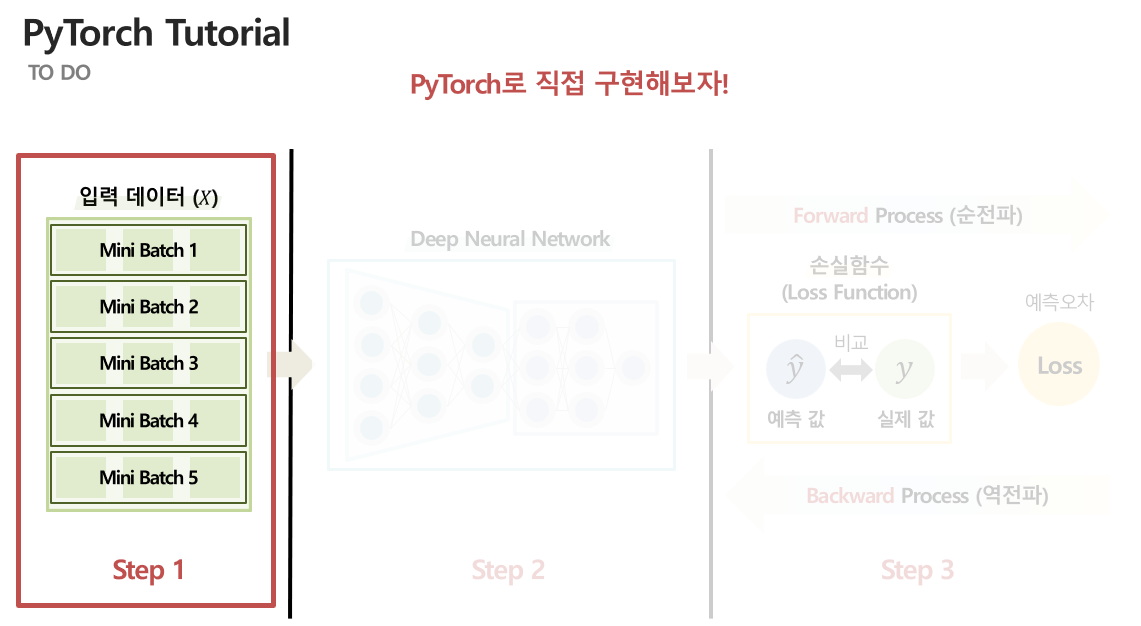

In [ ]:
Image('./images/dataset.png')

### torch.utils.data.Dataset을 상속받아 직접 Custom Dataset 만들기

In [ ]:
class CustomDataset(Dataset):
  def __init__(self):
    """객체가 생성될 때 초기화를 위해 호출하는 특수 메서드.
        데이터셋 구축을 위해 필요한 초기 설정을 수행하는 부분. (데이터 불러오기, 전처리 등)"""
    self.X = np.random.rand(5, 3)
    self.Y = np.random.randint(1, 5, (5,))

  def __len__(self):
    """데이터셋의 길이. 총 샘플의 수를 반환.
        len을 통해서 getitem의 idx 범위가 결정"""
    return len(self.X)

  def __getitem__(self, idx):
    """인덱스(idx)를 입력받아, 이에 대응되는 데이터를 return.
        데이터를 로드하고 (필요 시) 전처리 후 반환 필요"""
    return {'X': torch.tensor(self.X[idx]).float(),
            'Y': torch.tensor(self.Y[idx]).long()}

In [ ]:
d = CustomDataset()
print("데이터셋 총 샘플 수 확인: ", d.__len__())
print("데이터셋 0번째 샘플 가져오기: ", d.__getitem__(0))
print("데이터셋 0번째 X 샘플 가져오기: ", d.__getitem__(0)['X'])

데이터셋 총 샘플 수 확인:  5
데이터셋 0번째 샘플 가져오기:  {'X': tensor([0.7360, 0.2668, 0.2149]), 'Y': tensor(4)}
데이터셋 0번째 X 샘플 가져오기:  tensor([0.7360, 0.2668, 0.2149])


### Case 1. 데이터셋을 한 번에 불러올 수 있는 경우 Custom Dataset 만들기

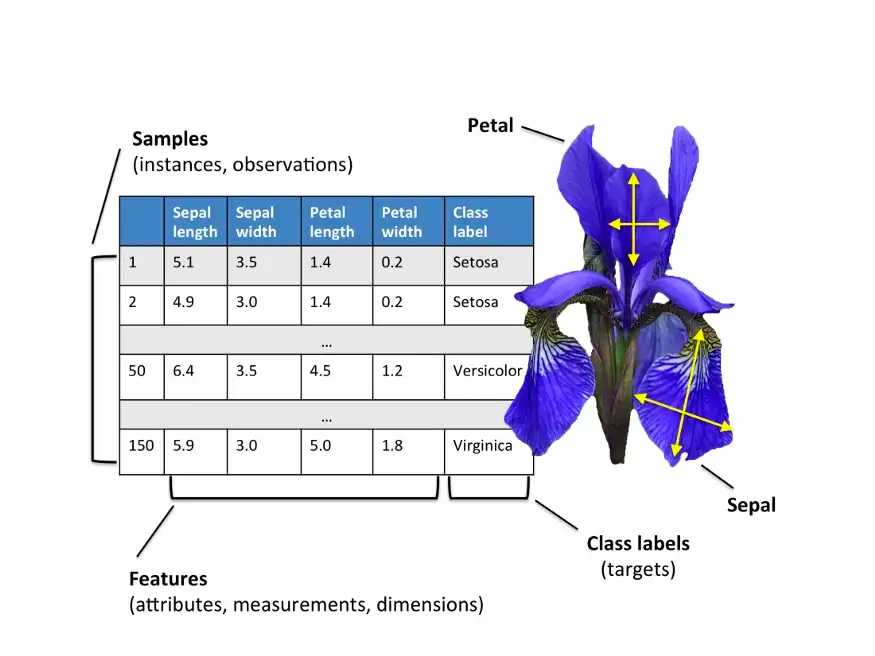

In [ ]:
Image('./images/iris_Data.PNG')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class IrisDataset(Dataset):
    def __init__(self, mode: str):  # 객체 생성을 위해서는 'mode'라는 인자가 필요하며 이는 str(문자형) 데이터 타입임
        """데이터 불러오기"""
        data = pd.read_csv('./data/Iris.csv')   # colab: data_dir = '/content/2024_LGE_DNNCNN/data/Iris.csv'

        """전처리"""
        # 1. 입력변수 X, 출력변수 y 분할
        X = data[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].to_numpy()  # numpy array로 변환
        y = data['Species'].to_numpy()

        # 2. 출력 변수 추가 전처리 (숫자로 변경)
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        # 3. 학습 / 검증 / 테스트 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # random_state는 데이터를 무작위로 분할할 때, 이후에 다시 분할해도 해당 데이터셋이 재현되도록 고정해주는 seed 값
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

        """IrisDataset 객체를 호출할 때 'mode'에 따라 정의될 X, y 값 지정"""
        if mode == "train":  # 만약 학습 단계라면,
            self.X, self.y = torch.FloatTensor(X_train), torch.LongTensor(y_train)
        elif mode == "valid": # 만약 검증 단계라면,
            self.X, self.y = torch.FloatTensor(X_valid), torch.LongTensor(y_valid)
        elif mode == "test": # 만약 테스트 단계라면,
            self.X, self.y = torch.FloatTensor(X_test), torch.LongTensory(y_test)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class IrisDataset2(Dataset):
    def __init__(self, mode: str):  # 객체 생성을 위해서는 'mode'라는 인자가 필요하며 이는 str(문자형) 데이터 타입임
        """전처리 된 데이터 불러오기"""
        X_train, X_valid, X_test, y_train, y_valid, y_test = self.preprocessing()

        """IrisDataset 객체를 호출할 때 'mode'에 따라 정의될 X, y 값 지정"""
        if mode == "train":  # 만약 학습 모드라면,
            self.X, self.y = torch.FloatTensor(X_train), torch.LongTensor(y_train)
        elif mode == "valid": # 만약 검증 단계라면,
            self.X, self.y = torch.FloatTensor(X_valid), torch.LongTensor(y_valid)
        elif mode == "test": # 만약 테스트 단계라면,
            self.X, self.y = torch.FloatTensor(X_test), torch.LongTensory(y_test)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    """전처리하여 가용 데이터셋을 구축하고 데이터를 분할하는 전반적인 작업을 따로 모듈화"""
    @staticmethod
    def preprocessing():
        data = pd.read_csv('./data/Iris.csv')   # colab: data_dir = '/content/2024_LGE_DNNCNN/data/Iris.csv'

        X = data[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].to_numpy()
        y = data['Species'].to_numpy()

        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

        return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
trainset = IrisDataset(mode='train')

print(trainset.__len__())         # 150 * .8 * .8 = 96
print(trainset.__getitem__(0))    # (X, y) # 첫 번째 인덱스의 데이터 살펴보기

96
(tensor([5.6000, 3.0000, 4.1000, 1.3000]), tensor(1))


In [ ]:
trainset = IrisDataset2(mode='train')

print(trainset.__len__())         # 150 * .8 * .8 = 96
print(trainset.__getitem__(0))    # (X, y) # 첫 번째 인덱스의 데이터 살펴보기

96
(tensor([5.6000, 3.0000, 4.1000, 1.3000]), tensor(1))


### Case 2. 데이터셋이 관측치마다 파일로 존재하는 경우 Custom Dataset 만들기

- 데이터가 어떤 경로로 되어있는지 확인 필요

In [ ]:
from glob import glob
from PIL import Image as Img

class CatDogDataset(Dataset):
    def __init__(self, mode: str):
        """데이터 불러오기 -> 데이터가 어떤 폴더에서 어떻게 구성되어 있는지 사전 확인 필요!"""
        # mode에 맞는 고양이 이미지 데이터
        cat_img_path = glob(f'./data/dog_cat/{mode}/cat/*')   # cf. '*'는 모든 파일 형태를 의미, 데이터 경로 설정 주의!
        cat_labels = [0]*len(cat_img_path)  # cat_img_path는 데이터 관측치의 경로가 담긴 리스트. 해당 변수의 length(길이)는 데이터 샘플의 수

        # mode에 맞는 강아지 이미지 데이터
        dog_img_path = glob(f'./data/dog_cat/{mode}/dog/*')
        dog_labels = [1]*len(dog_img_path)

        # 전체 데이터셋 구축
        self.img_path = cat_img_path + dog_img_path
        self.labels = cat_labels + dog_labels

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img = Img.open(self.img_path[idx])          # idx를 통해 특정 이미지의 경로를 선택한 뒤 오픈
        img = np.asarray(img)                       # 이미지를 numpy array로 변환 (H, W, C) ,(새로,가로,차원)
        X = torch.FloatTensor(img).permute(2,0,1)   # tensor 변환 및 축 변경 : C,H,W
        y = self.labels[idx]

        return X, y

In [ ]:
image_trainset = CatDogDataset(mode='train')
X, y = image_trainset.__getitem__(0)  # 첫 번째 인덱스의 데이터 살펴보기

print(image_trainset.__len__())       # 전체 trainset 개수는 202개
print(X.shape, y)                     # X는 3차원, label은 '0' (cat)

202
torch.Size([3, 374, 500]) 0


### Image 데이터셋: 시각화

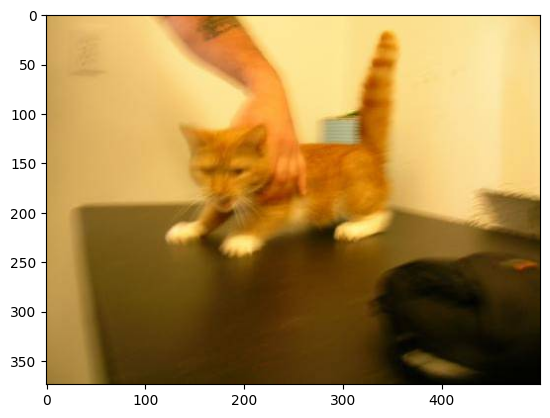

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X.permute(1,2,0).long().numpy());
plt.imshow(X.permute(1,2,0).div(255.).numpy());  #  RGB values (0-1 float or 0-255 int)

In [ ]:
testset = CatDogDataset(mode='test')
X, y = testset.__getitem__(0)

print(testset.__len__())
print(X.shape, y)

102
torch.Size([3, 500, 300]) 0


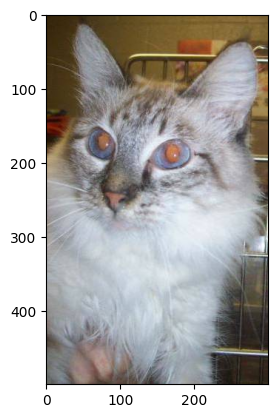

In [ ]:
plt.imshow(X.permute(1,2,0).long().numpy());
# plt.imshow(X.permute(1,2,0).div(255.).numpy());  #  RGB values (0-1 float or 0-255 int)

## DataLoader
- Dataset을 입력 받아 Batch size에 맞추어 데이터를 출력 및 로드(load)

In [ ]:
# dataset에서 batch size만큼의 데이터셋을 generate하는 역할
from torch.utils.data import DataLoader

"""Iris Dataset"""
trainloader = DataLoader(dataset=trainset,   # 어떤 데이터셋을 이용하여 batch 데이터를 load 할 것인지
                         batch_size=16,      # 몇 개의 데이터셋을 batch로 가져올 것인지 (한 bacth에 할당되는 데이터 수)
                         shuffle=True,       # 데이터 관측치를 무작위로 섞어서 학습할 지 (shuffle=True), 순차적으로 학습할 지 (shuffle=False)
                         num_workers=0,      # how many subprocesses to use for data (0=메인 프로세스에서 모든 데이터 로딩을 수행)
                                                ## 개인용 PC 윈도우에서는 일반적으로 num_workers=0만 가능, 그 외 1 이상의 값
                         drop_last=True)     # set to ``True`` to drop the last incomplete batch, if the dataset size is not divisible by the batch size.
                                                #######False 쓰면 다 쓰는 거래
                                                ## drop_last는 batch의 마지막 부분을 버릴지 사용할지 선택하는 인자 -> 장점: 모든 데이터셋 활용 가능 vs. 단점: batch size가 달라짐
print(trainloader)
print(trainset.y)  # class_names (0, 1, 2)

tensor([1, 0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 0,
        2, 0, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1,
        1, 0, 1, 0, 0, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 2,
        2, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 2, 1, 1, 1])


In [ ]:
for batch in trainloader:
    X, y = batch[0], batch[1]
    print(X.shape, y.shape)

torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([10, 3, 256, 256]) torch.Size([10])


In [ ]:
"""CatDog Image Dataset"""
trainloader = DataLoader(dataset=image_trainset,
                         batch_size=64,
                         shuffle=True,
                         num_workers=0,
                         drop_last=False)

In [ ]:
"""ERROR!"""
# **CatDog Data -> 이미지의 크기(width, height)가 서로 다르기 때문에 하나의 tensor로 stack할 수가 없음!
for batch in trainloader:
    X, y = batch[0], batch[1]
    print(X.shape, y.shape)

RuntimeError: stack expects each tensor to be equal size, but got [3, 306, 337] at entry 0 and [3, 396, 495] at entry 1

→ 데이터셋의 size를 맞춰주는 작업이 필요!  
→ 원본 이미지를 변환해주어야 함! (`transform`)

## Transform
- 대부분의 경우 데이터가 모델 학습에 필요한 형태로 가공되어 제공되지 않음
- 데이터를 목적에 맞는 형태로 가공 및 변형 (transform) 하여 조작하고 학습에 적합한 형태로 만들어야 함
- PyTorch torchvision 라이브러리는 'transforms'에서 다양한 변환 기능을 제공

(374, 500, 3)


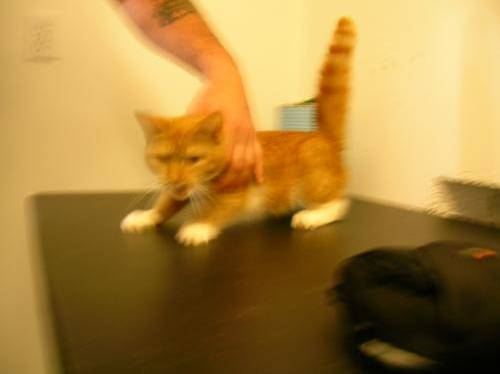

In [ ]:
# 이미지에 특화된 패키지인 torchvision을 통해 이미지 변형
import torchvision.transforms as tf

img = Img.open('./data/dog_cat/train/cat/cat.0.jpg')  # PIL 이용
print(np.asarray(img).shape)
img

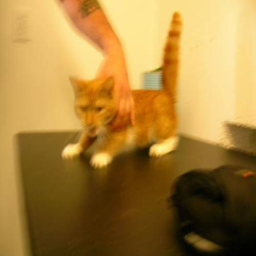

In [ ]:
# 이미지 사이즈 변경
resize = tf.Resize(size=(256, 256))
resize(img)

### Data Augmentation and Normalization
1. **Augmentation**
    - 일반화 성능 개선 : 모델이 입력 데이터의 패턴/특징을 파악하는 과정에서 다양한 특징을 학습할 수 있도록 하여 보다 일반화된 특성을 학습하도록 함
    - 데이터 diversity 증가 : 이미지 데이터의 경우, 각도, 크기, 조명 조건 등이 다양할 수 있음. 증강 기법을 통해 변형을 적용함으로써 모델이 다양한 시나리오에서 수집된 데이터셋에 강건할 수 있도록 함
    - 데이터가 부족한 상황에서도 사용 가능
    - 입력 데이터의 특성(e.g. time-series, 의료 영상 데이터 등)을 고려하여 적합한 방법론 도입 필요
2. **Normalization**
    - 학습 안정성 : Gradient Descent 알고리즘을 이용하여 파라미터를 업데이트할 때, 입력 데이터의 값(픽셀 값)을 0 근처의 작은 범위로 조정하면 학습이 더 안정적이고 빠르게 이루어짐 (값이 크면 가중치 업데이트가 불안정)
        - cf. 대부분의 딥러닝 모델은 작은 입력 값을 기준으로 학습되도록 설계됨
        - R, G, B 채널을 가진 이미지의 경우 모든 입력 채널이 비슷한 분포를 가지므로 학습 속도가 빨라지고 일반화 성능 향상
    - 다양한 이미지 소스에서 온 데이터를 사용할 때 서로 다른 값의 스케일을 동일하게 맞추어주는 효과
    - 일반화 성능 개선 : 모델이 특정 이미지의 밝기나 대비(contrast)에 과적합되는 것을 방지
    - 데이터의 평균과 표준편차를 이용하여 정규화 가능, 전체 데이터셋의 각 채널 별로 계산되어야 함 -> R, G, B 각 채널의 평균과 표준편차를 계산하여 정규화

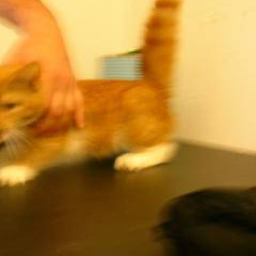

In [ ]:
# 이미지 랜덤 크롭
randomcrop = tf.RandomResizedCrop(size=(256,256))
randomcrop(img)

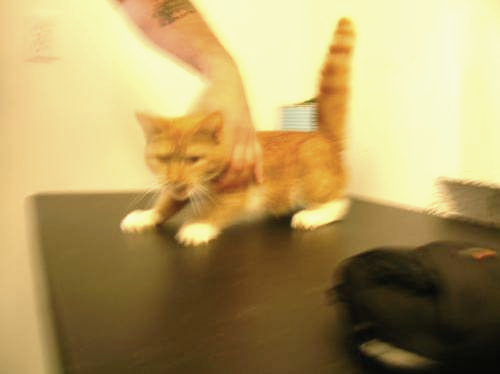

In [ ]:
# 밝기, 대비 등 colorjittering
colorjitter = tf.ColorJitter(0.5,0.5,0.5) # ColorJitter(brightness, contrast, saturation)
colorjitter(img)

In [ ]:
# 변형된 이미지를 tensor로 변환
totensor = tf.ToTensor()   # [0, 255] -> [0, 1]로 scaling해주기 위함
print(totensor(img))       # PIL 이미지를 0~1 scale로 변환
print(totensor(img).shape) # C,H,W 순서

tensor([[[0.7961, 0.7961, 0.8000,  ..., 0.9412, 0.9373, 0.9333],
         [0.7961, 0.7961, 0.8000,  ..., 0.9451, 0.9412, 0.9333],
         [0.7961, 0.7961, 0.8000,  ..., 0.9451, 0.9412, 0.9373],
         ...,
         [0.6000, 0.6000, 0.6000,  ..., 0.0078, 0.0078, 0.0078],
         [0.5961, 0.5961, 0.5961,  ..., 0.0078, 0.0078, 0.0078],
         [0.5922, 0.5922, 0.5922,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.6431, 0.6431, 0.6471,  ..., 0.7882, 0.7843, 0.7804],
         [0.6431, 0.6431, 0.6471,  ..., 0.7922, 0.7882, 0.7804],
         [0.6431, 0.6431, 0.6471,  ..., 0.7922, 0.7882, 0.7843],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.0078, 0.0078, 0.0078],
         [0.4745, 0.4745, 0.4745,  ..., 0.0078, 0.0078, 0.0078],
         [0.4706, 0.4706, 0.4706,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.3412, 0.3412, 0.3451,  ..., 0.4784, 0.4745, 0.4706],
         [0.3412, 0.3412, 0.3451,  ..., 0.4824, 0.4784, 0.4706],
         [0.3412, 0.3412, 0.3451,  ..., 0.4824, 0.4784, 0.

In [ ]:
# 데이터 정규화
# RGB채널에 대해서 각각 평균과 표준편차를 활용하여 정규화 (ImageNet이 학습한 수백만장의 이미지 RGB 각 채널의 평균과 표준편차)
normalize = tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 일반적인 조도/각도/사물체 등에 대한 이미지가 아닌 경우, 직접 데이터의 평균과 표준편차 계산 필요
print(normalize(totensor(img)))  # PIL 이미지를 tensor로 변환 후 정규화

print(np.asarray(img)[:, :, 0].mean(), '→',  np.asarray(normalize(totensor(img)))[:, :, 0].mean())  # R,G,B 3 채널 중 R채널에 대한 mean 값 확인
print(np.asarray(img)[:, :, 0].std(), '→', np.asarray(normalize(totensor(img)))[:, :, 0].std())    # R,G,B 3 채널 중 R채널에 대한 std 값 확인

tensor([[[ 1.3584,  1.3584,  1.3755,  ...,  1.9920,  1.9749,  1.9578],
         [ 1.3584,  1.3584,  1.3755,  ...,  2.0092,  1.9920,  1.9578],
         [ 1.3584,  1.3584,  1.3755,  ...,  2.0092,  1.9920,  1.9749],
         ...,
         [ 0.5022,  0.5022,  0.5022,  ..., -2.0837, -2.0837, -2.0837],
         [ 0.4851,  0.4851,  0.4851,  ..., -2.0837, -2.0837, -2.0837],
         [ 0.4679,  0.4679,  0.4679,  ..., -2.1008, -2.1008, -2.1008]],

        [[ 0.8354,  0.8354,  0.8529,  ...,  1.4832,  1.4657,  1.4482],
         [ 0.8354,  0.8354,  0.8529,  ...,  1.5007,  1.4832,  1.4482],
         [ 0.8354,  0.8354,  0.8529,  ...,  1.5007,  1.4832,  1.4657],
         ...,
         [ 0.1001,  0.1001,  0.1001,  ..., -2.0007, -2.0007, -2.0007],
         [ 0.0826,  0.0826,  0.0826,  ..., -2.0007, -2.0007, -2.0007],
         [ 0.0651,  0.0651,  0.0651,  ..., -2.0182, -2.0182, -2.0182]],

        [[-0.2881, -0.2881, -0.2707,  ...,  0.3219,  0.3045,  0.2871],
         [-0.2881, -0.2881, -0.2707,  ...,  0

In [ ]:
# 여러 transform 한 번에 적용
transform = tf.Compose([tf.RandomResizedCrop(size=(256,256)), # 무작위로 크롭하고 사이즈 변경
                        tf.RandomHorizontalFlip(p=0.5),       # 이미지를 뒤집는 증강기법
                        tf.RandomRotation(degrees=90),]       # 무작위로 이미지 회전
                        )

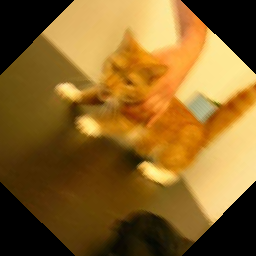

In [ ]:
transform(img)

In [ ]:
# getitem에서 데이터 변형 후 stack
class CatDogDataset2(Dataset):
    def __init__(self, mode: str):
        """데이터 불러오기"""
        self.mode = mode

        # mode에 맞는 고양이 이미지 데이터
        cat_img_path = glob(f'./data/dog_cat/{mode}/cat/*')   # cf. '*'는 모든 파일 형태를 의미
        cat_labels = [0]*len(cat_img_path)  # cat_img_path는 데이터 관측치의 경로가 담긴 리스트. 해당 변수의 length(길이)는 데이터 샘플의 수

        # mode에 맞는 강아지 이미지 데이터
        dog_img_path = glob(f'./data/dog_cat/{mode}/dog/*')
        dog_labels = [1]*len(dog_img_path)

        # 전체 데이터셋 구축
        self.img_path = cat_img_path + dog_img_path
        self.labels = cat_labels + dog_labels

    def __len__(self):
      return len(self.img_path)

    def __getitem__(self,idx):
      img = Img.open(self.img_path[idx]) # 이미지 오픈
      X = self.transform(img) # 이미지 변형

      y = self.labels[idx]

      return X, y

    def transform(self, img):
       if self.mode == 'train':
         transform = tf.Compose([
                                  # tf.ToPILImage(), 만약 데이터가 array나 tensor로 되어 있는 경우 PILImage로 변경이 필요
                                  tf.RandomResizedCrop(size=(256,256)),  # 데이터 사이즈를 **랜덤하게** 조정하고 crop까지
                                  tf.RandomHorizontalFlip(p=0.5),        # 주어진 확률로 이미지를 무작위로 수평 flip(뒤집기)
                                  tf.ToTensor(),                         # PIL image를 tensor로 변환 -> 0~1 사이의 값으로 픽셀 값이 조정됨
                                  # tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # RGB채널에 대해서 각각 평균과 표준편차를 활용하여 정규화 (ImageNet이 학습한 수백만장의 이미지 RGB 각 채널의 평균과 표준편차)
                                                                                              # 일반적인 조도/각도/사물체 등에 대한 이미지가 아닌 경우, 직접 데이터의 평균과 표준편차 계산 필요
                                                ])
       else: # 테스트의 경우에는 이미지 증강기법을 적용하면 안됨! (Resize도 랜덤 적용 대신 원본 이미지의 사이즈만 맞춰주기)
          transform = tf.Compose([
                                  tf.Resize(size=(256,256)),
                                  tf.ToTensor(),
                                  # tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # RGB채널에 대해서 각각 평균과 표준편차를 활용하여 정규화
                                  ])


       return transform(img)

torch.Size([3, 256, 256])


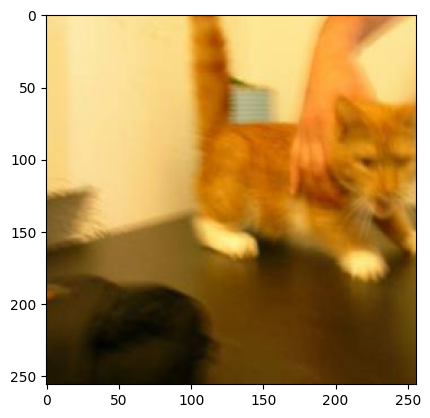

In [ ]:
trainset3 = CatDogDataset2(mode='train')
testset3 = CatDogDataset2(mode='test')
X, y = trainset3.__getitem__(0)

print(X.shape)
plt.imshow(X.permute(1,2,0).numpy());

torch.Size([3, 256, 256])


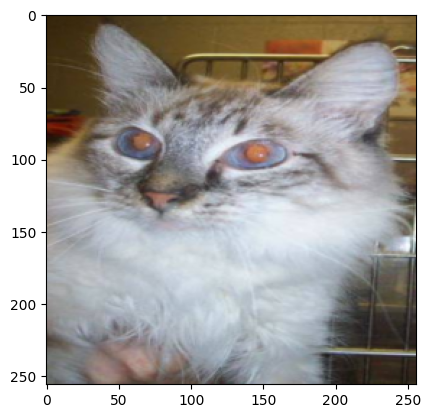

In [ ]:
X, y = testset3.__getitem__(0)

print(X.shape)
plt.imshow(X.permute(1,2,0).numpy());

In [ ]:
trainloader = DataLoader(dataset=trainset3,
                         batch_size=64,
                         shuffle=True,
                         num_workers=0,
                         drop_last=False)

for batch in trainloader:
    X, y = batch[0], batch[1]
    print(X.shape, y.shape)

torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([10, 3, 256, 256]) torch.Size([10])
